# Multi-Class Logistic Regression in Python

## Load the MNIST dataset

In [1]:
import pandas as pd
import numpy as np

names = ['label']
feature_names = map(str, range(784))
names.extend(feature_names)

df_mnist_train = pd.read_csv('mnist_train.csv', header=None, nrows=1000, names=names)
df_mnist_test = pd.read_csv('mnist_test.csv', header=None, nrows=100, names=names)

# normalize pixel data (otherwise pure python implemention won't work)
max_pixel =  255
df_mnist_train.iloc[:, 1:] /= max_pixel
df_mnist_test.iloc[:, 1:] /= max_pixel

print df_mnist_train.shape, df_mnist_test.shape

(1000, 785) (100, 785)


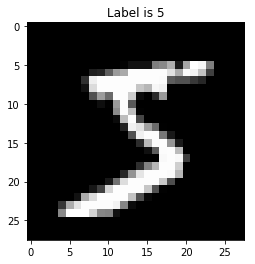

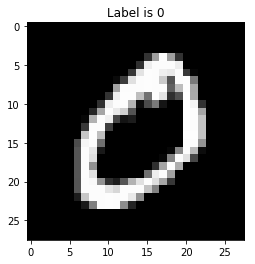

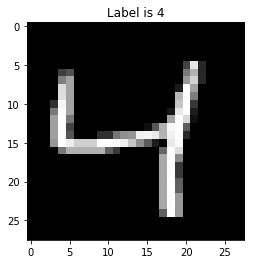

In [2]:
# plot the first 3 examples of the mnist train dataset

import matplotlib.pyplot as plt

n_examples = 3
for i in range(n_examples):
    example = df_mnist_train.iloc[i,:].values
    label = int(example[0])

    pixels = example[1:]
    pixels = np.array(pixels)
    pixels = pixels.reshape((28, 28))

    plt.title('Label is {}'.format(label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [3]:
# select subset of features and labels 

X_train, y_train = df_mnist_train.iloc[:, 1:], df_mnist_train['label']
X_test, y_test = df_mnist_test.iloc[:, 1:], df_mnist_test['label']

print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(1000, 784) (1000,)
(100, 784) (100,)


## Part 1: Sklearn Implementation

In [4]:
from sklearn.linear_model import LogisticRegression

# instantiate and fit model
model_1 = LogisticRegression()
model_1 = model_1.fit(X_train, y_train)

# evaluate model
train_acc =  model_1.score(X_train, y_train)
test_acc =  model_1.score(X_test, y_test)
print 'Train accuracy: {}'.format(train_acc)
print 'Test accuracy: {}'.format(test_acc)

Train accuracy: 0.998
Test accuracy: 0.91


## Part 2: Tensorflow Implementation
###  Adapted from Tensorflow Documentation

In [5]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# define model input
def input_fn(x, y):
    feature_cols = {name: tf.constant(x[name].values) for name in x.columns}
    label = tf.constant(y.values)
    return feature_cols, label


# define features
feat_cols = [tf.contrib.layers.real_valued_column(name) for name in X_train.columns]

# instantiate and fit model
model_2 = tf.contrib.learn.LinearClassifier(feature_columns=feat_cols, n_classes=10) # need to specify n_classes
model_2.fit(input_fn=lambda: input_fn(X_train, y_train), steps=100)

# evaluate model
train_acc = model_2.evaluate(input_fn=lambda: input_fn(X_train, y_train), steps=1)['accuracy']
test_acc = model_2.evaluate(input_fn=lambda: input_fn(X_test, y_test), steps=1)['accuracy']
print 'Train accuracy: {}'.format(train_acc)
print 'Test accuracy: {}'.format(test_acc)

Train accuracy: 0.885999977589
Test accuracy: 0.829999983311


## Part 3: Pure Python Implementation

In [6]:
class MultiClassLogisticRegressorPurePython(object):
    
    def __init__(self, lr, n_iter):
        self.lr = lr
        self.n_iter = n_iter

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.m_ = X.shape[0]
        self.w_ = np.zeros((X.shape[1], self.n_classes_))
        self.cost_ = []
        
        
        for i in range(self.n_iter):
            z = self.net_input(X)
            assert not np.isnan(np.sum(z))
            p_y = self.softmax_fn(z)
            y_onehot = self.onehot_fn(y)
            error = (y_onehot - p_y)
            grad =  (-1 / self.m_) * X.T.dot(error) 
            self.w_ = self.w_ - (self.lr * grad)
                
        
            cost = (-1 / self.m_) * np.sum(y_onehot * np.log(p_y))
            self.cost_.append(cost)
            
        return self
    
    def onehot_fn(self, y):
        onehot = np.eye(self.n_classes_)[y]
        return onehot

    def net_input(self, X):
        return np.dot(X, self.w_)

    def predict(self, X):
        z = self.net_input(X)
        return np.argmax(self.softmax_fn(z), axis=1)
    
    def softmax_fn(self, z):
        z -= np.max(z)
        softmax = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
        return softmax
    

# instantiate and fit model
model_3 = MultiClassLogisticRegressorPurePython(n_iter=100, lr=0.001)
model_3.fit(X_train.values, y_train.values)

# evaluate model
train_acc = np.sum(model_3.predict(X_train) == y_train) / float(len(X_train))
test_acc = np.sum(model_3.predict(X_test) == y_test) / float(len(X_test))
print 'Train accuracy: {}'.format(train_acc)
print 'Test accuracy: {}'.format(test_acc)

Train accuracy: 0.968
Test accuracy: 0.88


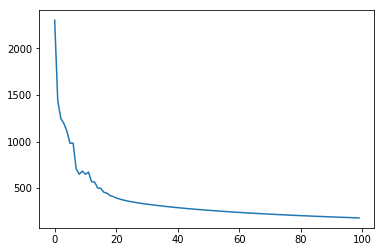

In [7]:
plt.plot(model_3.cost_)
plt.show()